In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykal.control_system.system import System
from numpy.typing import NDArray
from typing import Callable

# Radar and time settings
d = 10000
h0 = 10000
dt = 0.005
# Constants
po = 2  # lb sec^2 / ft^4
g = 9.81  # m / sec^2
kp = 6100  # m (air density with altitude)


def Q_fall() -> NDArray:
    return np.zeros((3, 3))


def R_radar() -> NDArray:
    return np.array([[1000]])

# Measurement function
def h_range(x: NDArray) -> NDArray:
    return np.array([np.sqrt(d**2 + (x[0] - h0) ** 2)])


# Dynamics function (true continuous)
def true_dynamics(t: float, x: NDArray) -> NDArray:
    x = x.flatten()
    dx1 = x[1]
    dx2 = np.exp(-x[0] / kp) * (x[1] ** 2) * x[2] - g
    dx3 = 0.0
    return np.array([[dx1], [dx2], [dx3]])


# Discrete dynamics for propagation
def f_discrete_dyn(tk: float, xk: NDArray) -> NDArray:
    return xk + dt * true_dynamics(tk, xk)

state_names = ["altitude", "velocity", "ballistic_coeff"]
measurement_name = ["slant_range"]
sys = System(
    f=f_discrete_dyn,
    state_names=state_names,
    h=h_range,
    measurement_names=measurement_name,
    system_type="dti",
    R=R_radar,
    Q=Q_fall,
)


<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

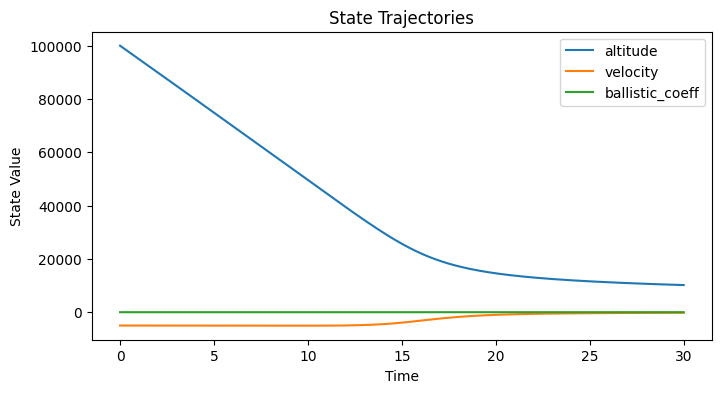

In [2]:
# Initial truth state: position, velocity, ballistic coeff
x0 = np.array([100000, -5000, 3e-3], dtype=np.float64).reshape(-1,1)
dt = 0.005
t_span = (0,30)

X_df = sys.simulate_states(x0=x0, 
                           t_span=t_span, 
                           dt=dt,
                           output_df=True)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

<Axes: title={'center': 'Measureument Trajectory'}, xlabel='Time', ylabel='Value'>

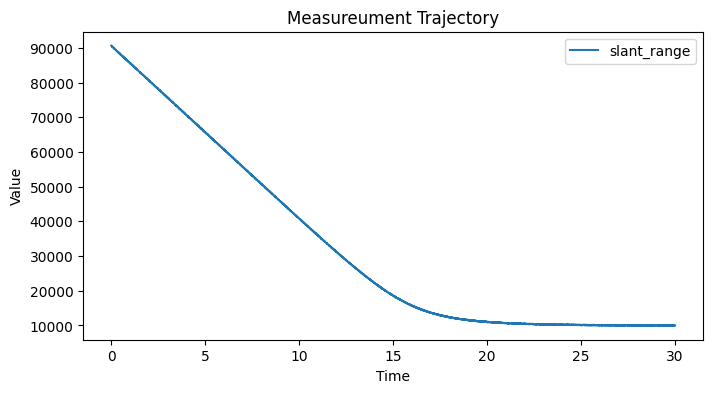

In [3]:
Y_df = sys.simulate_measurements(X_df=X_df,input_df=True,output_df =True)
Y_df.plot(title="Measureument Trajectory", xlabel="Time", ylabel="Value", figsize=(8, 4))

In [9]:
import pandas as pd
from pykal.control_system.observer import Observer
# Initial uncertainty 
P0 = np.diag(np.array([10000**2, 500**2, 0.03**2]))
# Linearized measurement Jacobian
def Hk_lin(xk: NDArray) -> NDArray:
    x = xk.flatten()
    denom = np.sqrt(d**2 + (x[0] - h0) ** 2)
    return np.array([[(x[0] - h0) / denom, 0, 0]])


# Linearized F matrix
def F_linearized_discrete(x:NDArray) -> NDArray:
    F = np.eye(3)
    F[1, 0] = (x[1] ** 2 * x[2]) * np.exp(-x[0] / kp) * (-1 / kp)
    F[1, 1] = 2 * np.exp(-x[0] / kp) * x[1] * x[2]
    F[1, 2] = np.exp(-x[0] / kp) * x[1] ** 2
    F *= dt
    return np.eye(3) + F

obs = Observer(sys)
x_est = x0 + np.random.multivariate_normal(mean=[0, 0,0], cov=P0).reshape(3,1)


obs.ekf.F = F_linearized_discrete
obs.ekf.H = Hk_lin

X_est_df, P_est_sr = obs.ekf.run(x0=x_est,P0=P0,Y_df=Y_df, input_df=True, output_df=True)

/tmp/ipykernel_11684/4251469748.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[1, 0] = (x[1] ** 2 * x[2]) * np.exp(-x[0] / kp) * (-1 / kp)
/tmp/ipykernel_11684/4251469748.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[1, 1] = 2 * np.exp(-x[0] / kp) * x[1] * x[2]
/tmp/ipykernel_11684/4251469748.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[1, 2] = np.exp(-x[0] / kp) * x[1] ** 2


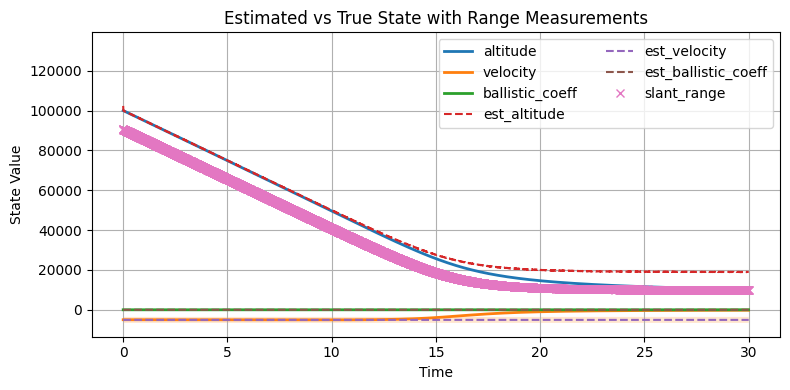

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot true states
X_df.plot(ax=ax, linewidth=2)

# Plot estimates (dashed)
X_est_df.plot(ax=ax, linestyle="--")

# Plot measurements
Y_df.plot(ax=ax, style="x")

# Add ±3σ confidence intervals for each state
for i, col in enumerate(X_est_df.columns):
    mean = X_est_df[col]
    std = np.sqrt([P[i, i] for P in P_est_sr])  # assumes P_est is a list of (n, n) cov matrices
    ax.fill_between(
        X_est_df.index,
        mean - 3 * std,
        mean + 3 * std,
        alpha=0.2,
    )

ax.set_title("Estimated vs True State with Range Measurements")
ax.set_xlabel("Time")
ax.set_ylabel("State Value")
ax.grid(True)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()


In [11]:
from pykal.utils import compute
state_observability_over_time = compute.Observability.of_states_over_time_from_grammian_via_callable(sys=sys,
                                                                                                     x0=x0,
                                                                                                     grammian_to_scores_func=compute.Observability.of_states_from_grammian_nullspace,
                                                                                                     t_span=t_span,
                                                                                                     dt=dt,
                                                                                                    divide_time_into_k_windows=353,
                                                                                                    output_df=True)


<Axes: xlabel='time'>

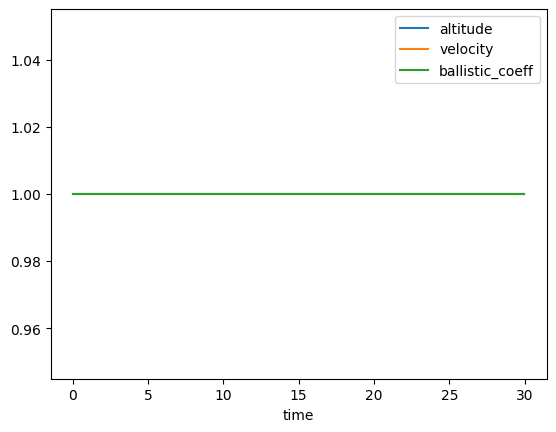

In [12]:
state_observability_over_time.plot()

In [13]:
def nullspace_beta(tk: float) -> NDArray:
    """
    Return the observability-based beta vector at time closest to `tk`.
    """
    index_array = state_observability_over_time.index.to_numpy()
    closest_idx = np.abs(index_array - tk).argmin()
    closest_time = index_array[closest_idx]
    row = state_observability_over_time.loc[closest_time]
    return row.to_numpy()

In [14]:
def static_beta() -> NDArray:
    return np.array([[1],[1],[0.75]])

In [15]:
static_beta_log = pd.DataFrame(columns=state_names)
X_est_df, P_est_sr = obs.ekf.run(x0=x_est,P0=P0,Y_df=Y_df, input_df=True, output_df=True,override_update=obs.ekf.override_update_partial(static_beta,static_beta_log))

/tmp/ipykernel_11684/4251469748.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[1, 0] = (x[1] ** 2 * x[2]) * np.exp(-x[0] / kp) * (-1 / kp)
/tmp/ipykernel_11684/4251469748.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[1, 1] = 2 * np.exp(-x[0] / kp) * x[1] * x[2]
/tmp/ipykernel_11684/4251469748.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[1, 2] = np.exp(-x[0] / kp) * x[1] ** 2
/tmp/ipykernel_11684/4251469748.py:15: DeprecationWarning: Conve

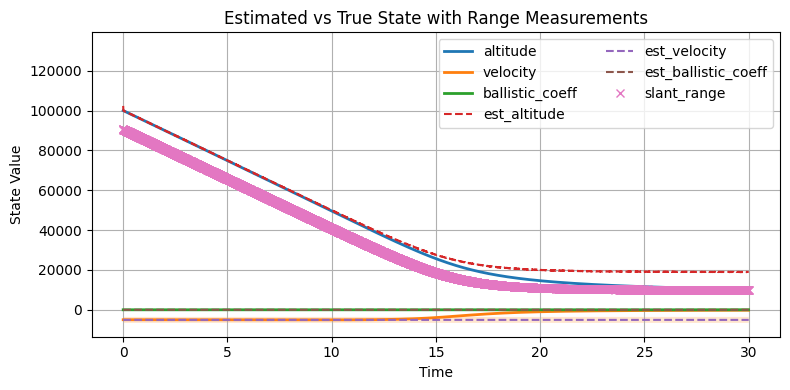

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot true states
X_df.plot(ax=ax, linewidth=2)

# Plot estimates (dashed)
X_est_df.plot(ax=ax, linestyle="--")

# Plot measurements
Y_df.plot(ax=ax, style="x")

# Add ±3σ confidence intervals for each state
for i, col in enumerate(X_est_df.columns):
    mean = X_est_df[col]
    std = np.sqrt([P[i, i] for P in P_est_sr])  # assumes P_est is a list of (n, n) cov matrices
    ax.fill_between(
        X_est_df.index,
        mean - 3 * std,
        mean + 3 * std,
        alpha=0.2,
    )

ax.set_title("Estimated vs True State with Range Measurements")
ax.set_xlabel("Time")
ax.set_ylabel("State Value")
ax.grid(True)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()